In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
from copy import copy
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import math
import cmocean

In [2]:
datadir = '/Users/rfische1/Documents/UU/'
        #'/data/oceanparcels/output_data/data_Delphine/' 
        #'/nethome/lobel001/biofouling_3dtransport_2/Simulation/Sim_output/' 
        #/data/oceanparcels/output_data/data_Reint/' #

In [3]:
regions = {'EqPac': 'Equatorial Pacific'}
r_pl_clist = ['#7a0177','#c51b8a','#f768a1', '#fbb4b9']
r_pl_cmap = plt.get_cmap('RdPu_r')

In [4]:
runtime = 458 #822        # [days]
start_yr = 2003
biofouling = 'MEDUSA'
rho_bf = 1170 #
rho_pl = [920, 1020]

In [5]:
region = 'EqPac'
dt = 60                       # [seconds]
outputdt = 12                 # [hours]
mixing = 'markov_0_'+biofouling
time_plot = round((runtime-91)*24/outputdt)
sizebinedges = [1e-3, 1e-4, 1e-5]
res ='1x1'
proc = 'bfnoadv'
season = 'Oct'
season_string = {'Jan':'January - July', 'MAM':'March - September', 'JJA':'June - December', 'SON':'September - March','DJF':'December - June'}

In [6]:
ds_0 = xr.open_dataset(datadir+'regional_'+region+'_'+proc+'_'+season+'_'+str(start_yr)+'_'+res+'res_'+mixing+'_'+str(rho_bf)+'rhobf_'+str(rho_pl[0])+'rhopl_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')
ds_1 = xr.open_dataset(datadir+'regional_'+region+'_'+proc+'_'+season+'_'+str(start_yr)+'_'+res+'res_'+mixing+'_'+str(rho_bf)+'rhobf_'+str(rho_pl[1])+'rhopl_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')

In [7]:
dslist = [ds_0, ds_1]

In [8]:
mld_0 = np.mean(ds_0['mld'][:,1:],axis=0)
ez_0 = np.mean(ds_0['euphz'][:,1:],axis=0)
mld_0 = np.concatenate(([mld_0[0]],mld_0))
ez_0 = np.concatenate(([ez_0[0]],ez_0))

mld_1 = np.mean(ds_1['mld'][:,1:],axis=0)
ez_1 = np.mean(ds_1['euphz'][:,1:],axis=0)
mld_1 = np.concatenate(([mld_1[0]],mld_1))
ez_1 = np.concatenate(([ez_1[0]],ez_1))

In [9]:
mldlist = [mld_0, mld_1]
ezlist = [ez_0, ez_1]

In [11]:
obs_ids=[-time_plot,-1]  # one year

In [12]:
split_ds_0 = list(ds_0.groupby_bins('r_pl',sizebinedges[::-1]))[::-1]
split_ds_1 = list(ds_1.groupby_bins('r_pl',sizebinedges[::-1]))[::-1]
split_dslist = [split_ds_0, split_ds_1]

In [13]:
depthbins = np.concatenate((np.linspace(0,445,90), np.linspace(450,5500,102)))
sub_depths = [[0,91],[90,len(depthbins)]]
starttimes=(ds_0['time'][0,obs_ids[0]:obs_ids[1]]-np.timedelta64(int(outputdt/2.), 'h')).values
endtime = (ds_0['time'][0,obs_ids[1]]+np.timedelta64(int(outputdt/2.), 'h')).values
timebins = np.append(starttimes,endtime)
daybins =(timebins-timebins[0]).astype(np.float64)*(np.timedelta64(1,'ns') / np.timedelta64(1,'D'))
timeperiod = obs_ids[1]-obs_ids[0]

In [14]:
depth_densities = np.zeros((len(dslist),len(split_ds_1),timeperiod,len(depthbins)-1))
depth_numbers = np.zeros((len(dslist),len(split_ds_1),timeperiod,len(depthbins)-1))

for k in range(len(dslist)):
    split_ds = split_dslist[k]
    for i in range(len(depth_densities[0])):
        for j in range(timeperiod):
            values, bins = np.histogram(split_ds[i][1]['z'].isel(obs=obs_ids[0]+j), depthbins)
            depth_numbers[k,i,j] = values/np.diff(depthbins)

In [15]:
depth_cmap = copy(plt.get_cmap('magma'))

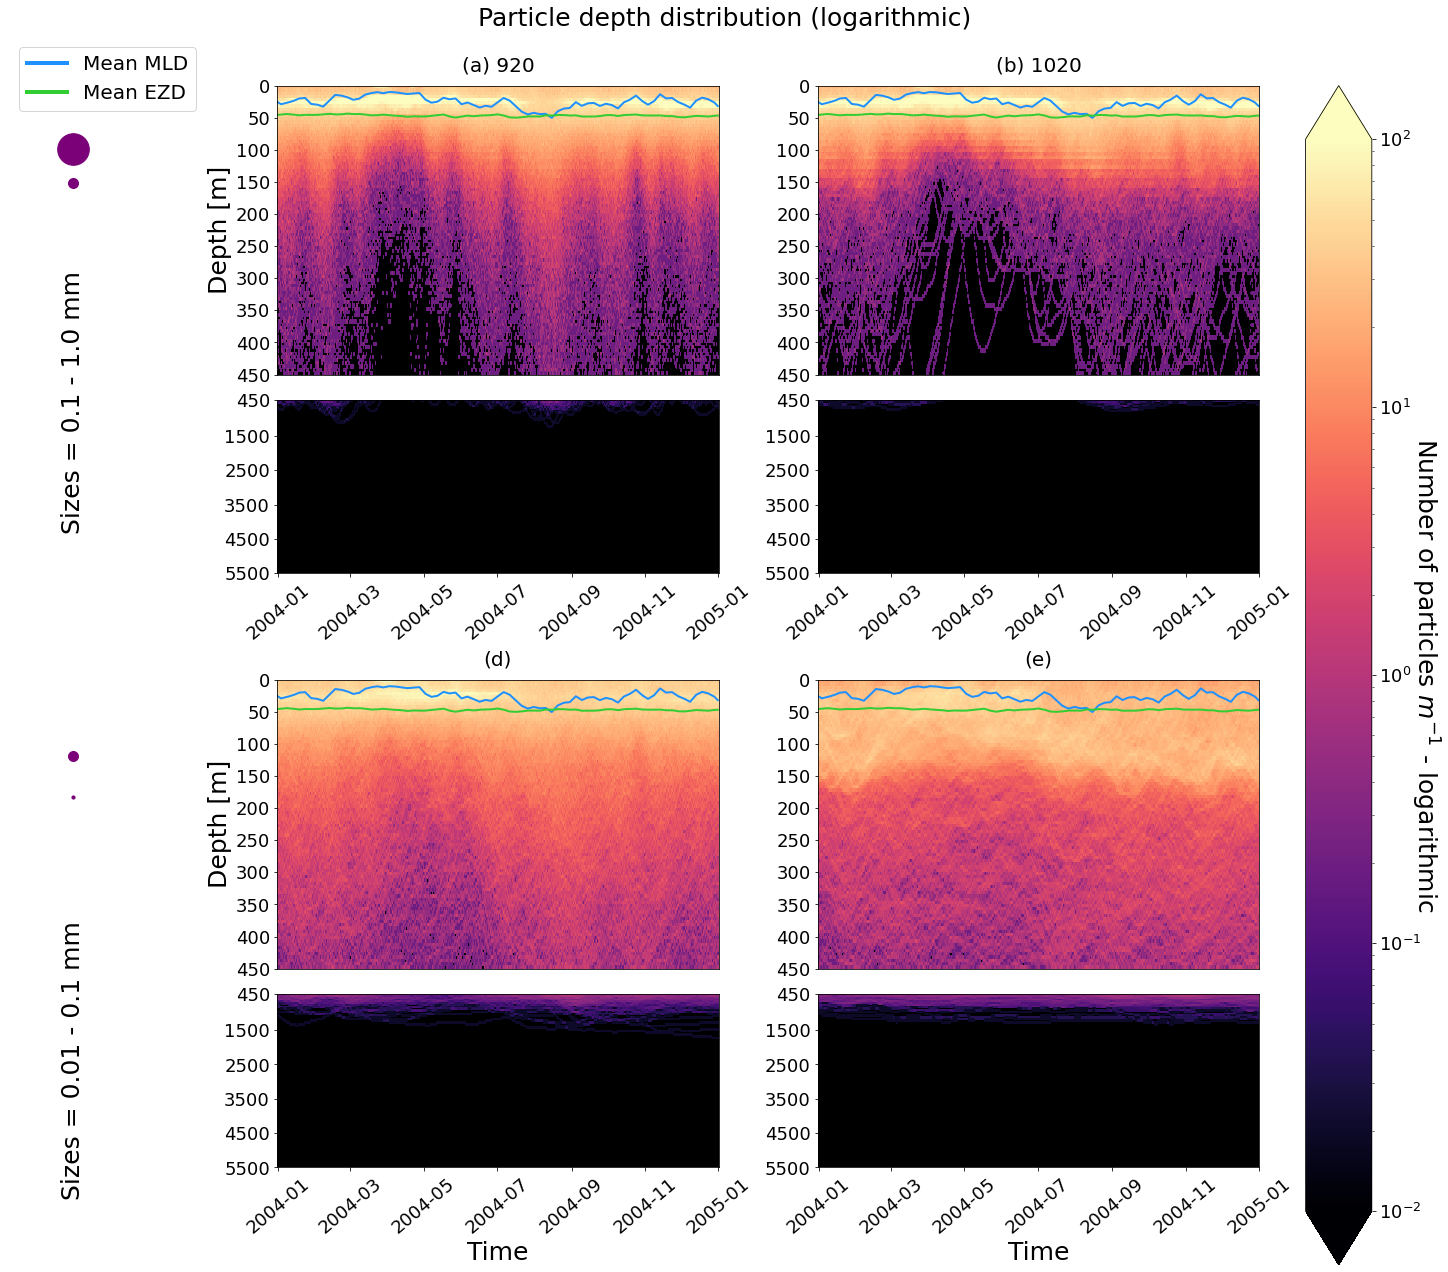

In [16]:
fig = plt.figure(figsize=(20,17),constrained_layout=True)
gs = gridspec.GridSpec(ncols=5, nrows=17, width_ratios=[0.3,1,1,1,0.15], figure=fig)
ax1 = fig.add_subplot(gs[:8, 0])
ax2 = fig.add_subplot(gs[8:, 0])

ax3 = fig.add_subplot(gs[:5, 1])
ax4 = fig.add_subplot(gs[5:8, 1]) 
ax5 = fig.add_subplot(gs[8:13, 1])
ax6 = fig.add_subplot(gs[13:16, 1])

ax7 = fig.add_subplot(gs[:5, 2])
ax8 = fig.add_subplot(gs[5:8, 2])
ax9 = fig.add_subplot(gs[8:13, 2])
ax10 = fig.add_subplot(gs[13:16, 2])

ax15 = fig.add_subplot(gs[:17, 4])
axes = [[ax1, ax2],[[ax3,ax4],[ax5,ax6]],[[ax7,ax8],[ax9,ax10]]]

for i, ax_r in enumerate(axes[1:]):   # column: region
    for c, ax_s in enumerate(ax_r):   # row: size
        for j, ax in enumerate(ax_s): # subfigure: depth
            ax.set_facecolor('k')
            ax.tick_params(axis='both', labelsize=18)#13
            pc = ax.pcolormesh(timebins,depthbins[sub_depths[j][0]:sub_depths[j][1]],depth_numbers[i,c,:,sub_depths[j][0]:sub_depths[j][1]-1].T, cmap=depth_cmap,norm=mcolors.LogNorm(vmin=1e-2, vmax=1e2))
            if j == 0:
                ax.plot(dslist[i]['time'][0,obs_ids[0]:obs_ids[1]], mldlist[i][obs_ids[0]:obs_ids[1]], linewidth=2, c='dodgerblue', label='Mean Mixed Layer Depth')
                ax.plot(dslist[i]['time'][0,obs_ids[0]:obs_ids[1]], ezlist[i][obs_ids[0]:obs_ids[1]], linewidth=2, c='limegreen', label='Mean Euphotic Depth')
                ax.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
                
                n=c*3+i
                ax.set_ylim(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]])
                ax.set_yticks(np.arange(450,-10,-50))
#                 ax.set_yticks(np.concatenate((np.arange(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]],-50),[depthbins[sub_depths[j][0]]])))
                if c == 0:
                    ax.set_title('('+chr(ord('a')+n)+') '+ str(rho_pl[i]), fontsize=20, y=1.03)
                else:
                    ax.set_title('('+chr(ord('a')+n)+')', fontsize=20, y=1.03)
                if i == 0:
                    ax.set_ylabel('Depth [m]', fontsize=25)#14
            if j == 1:
                ax.set_ylim(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]])
                ax.set_yticks([5500,4500,3500,2500,1500,450])
#                 ax.set_yticks((np.arange(depthbins[sub_depths[j][1]-1], depthbins[sub_depths[j][0]],-1000)))
                ax.tick_params(axis='x', rotation=40) #20)
                if c == 1:
                    ax.set_xlabel('Time', fontsize=25) #14)
 
        
cb = fig.colorbar(pc, cax=ax15, extend='both')
cb.set_label('Number of particles $m^{-1}$ - logarithmic', size=25, rotation=270, labelpad=20)
cb.ax.tick_params(labelsize=18) #13)

fig.suptitle('Particle depth distribution (logarithmic)', fontsize=25, y=1.03) #20) #January 2004 - January 2005 
#plt.subplots_adjust(top=0.92)
#fig.tight_layout(h_pad=1)
#fig.tight_layout()
for k, ds_r in enumerate(split_ds_0):
    axes[0][k].scatter(0.5,0.87,s=sizebinedges[k]*1000000,color=r_pl_clist[0])
    axes[0][k].scatter(0.5,0.80,s=sizebinedges[k+1]*1000000,color=r_pl_clist[0])
    axes[0][k].set_ylim(0,1)
    axes[0][k].text(0.5,0.35,'Sizes = '+ str(ds_r[0].left*1000)+' - '+str(ds_r[0].right*1000)+' mm',rotation=90, fontsize=25, horizontalalignment='center',verticalalignment='center')
    axes[0][k].axis('off')
    
custom_lines = [Line2D([0], [0], color='dodgerblue', lw=4),
                Line2D([0], [0], color='limegreen', lw=4)]

ax1.legend(custom_lines, ["Mean MLD", "Mean EZD"], loc='upper right', fontsize=20, bbox_to_anchor=(1.5,1.1))
# plt.savefig(datadir+'fig02_adv')